In [1]:
# Imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import re
import seaborn as sns
from textblob import TextBlob
import string
import keras
keras.__version__
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten,Dense
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence  import pad_sequences
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
#pip install -U gensim
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
# Compute Perplexity for lda_model
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
np.random.seed(2018)

Using TensorFlow backend.
C:\Users\Ahmed\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The original data is contained in 9 csv files. We load these files and concatenate them into one single dataframe that we save to a csv file to make the loading process easier in the future

In [2]:
'''
# You should skip this part if the aggregate csv file is already saved.
# Loading data and concatenating into one dataframe
PATH = "../russian-troll-tweets"
filenames = glob.glob(os.path.join(PATH, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in filenames))
# Save dataframe to one single csv file to facilitate loading
df.to_csv('IRA_tweets.csv')
'''

'\n# You should skip this part if the aggregate csv file is already saved.\n# Loading data and concatenating into one dataframe\nPATH = "../russian-troll-tweets"\nfilenames = glob.glob(os.path.join(PATH, "*.csv"))\ndf = pd.concat((pd.read_csv(f) for f in filenames))\n# Save dataframe to one single csv file to facilitate loading\ndf.to_csv(\'IRA_tweets.csv\')\n'

# Exploratory analysis

We begin by loading the entire dataset and cleaning the tweets by removing the urls, the digits, multipe white spaces and symbols.

In [3]:
df = pd.read_csv('IRA_tweets.csv',engine='python').drop(['Unnamed: 0'],axis=1)

In [4]:
# The attributes of the data with the corresponding type
df.dtypes

external_author_id    float64
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
new_june_2018           int64
retweet                 int64
account_category       object
dtype: object

In [5]:
#Let's look at the total number of authors of these tweets
df.author.nunique()

2774

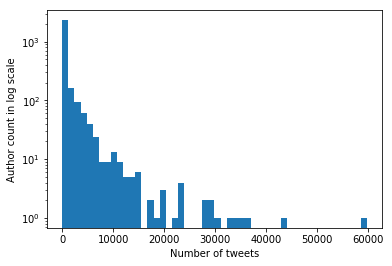

In [6]:
plt.hist(df.author.value_counts(),bins =50,log=True)
plt.xlabel('Number of tweets')
plt.ylabel('Author count in log scale')
plt.show()

In [7]:
#Let's havev a look at the top 5 authors
top_authors = df.author.value_counts().head(6).index
print(top_authors)

Index(['EXQUOTE', 'SCREAMYMONKEY', 'WORLDNEWSPOLI', 'AMELIEBALDWIN',
       'TODAYPITTSBURGH', 'SPECIALAFFAIR'],
      dtype='object')


In [8]:
for author in top_authors:
    print(df[df['author']==author].groupby('account_category').size())

account_category
Commercial    59652
dtype: int64
account_category
NewsFeed    44041
dtype: int64
account_category
RightTroll    36974
dtype: int64
account_category
RightTroll    35371
dtype: int64
account_category
NewsFeed    33602
dtype: int64
account_category
NewsFeed    32588
dtype: int64


In [9]:
# Get the aggregate number of tweets for the top 119 authors
df.author.value_counts().head(119).sum()

1467693

In [10]:
int(len(df)/2)

1456521

We can see that the top 119 authors (accounts) are responsible for roughly half the total number of tweets.

Text(0.5, 1.0, 'Languages count')

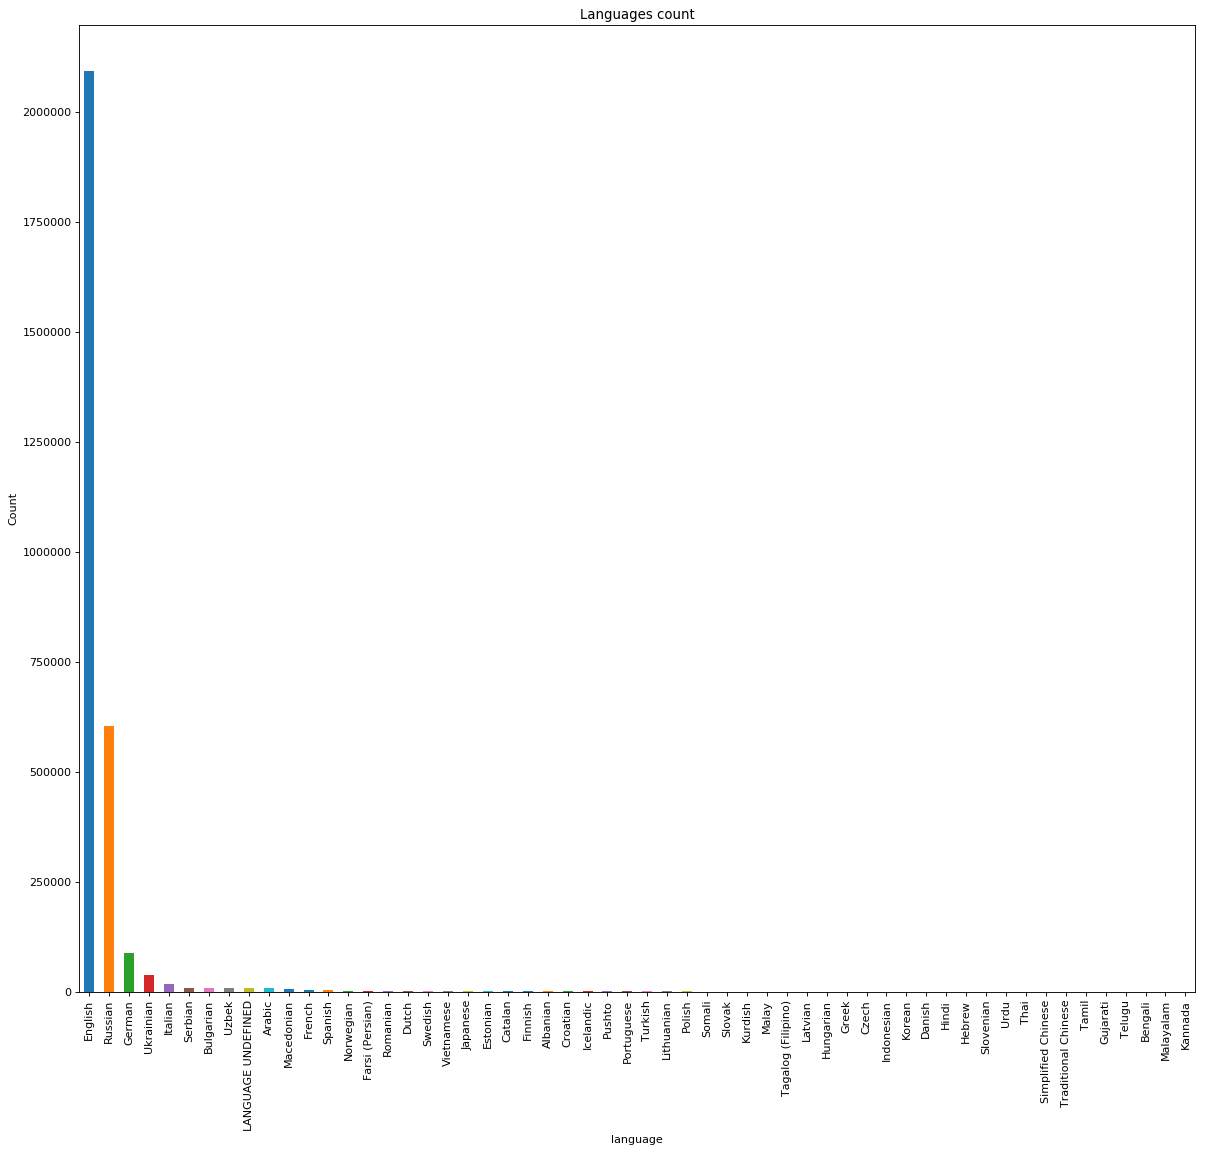

In [11]:
lang_df = df.groupby(['language']).size().sort_values(ascending = False)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
lang_df.plot.bar()
plt.ylabel('Count')
plt.title('Languages count')

In [12]:
proportion_eng = lang_df.English*100/len(df)
proportion_rus = lang_df.Russian*100/len(df)
print('The proportion of English tweets is ',proportion_eng)
print('The proportion of Russian tweets is ',proportion_rus)
print('The number of languages figuring in the dataset is',len(lang_df))

The proportion of English tweets is  71.83346481101199
The proportion of Russian tweets is  20.72812544412336
The number of languages figuring in the dataset is 56


Nore than 92% of the tweets are in English or Russian. We will therefore restrict further analysis to only the tweets in English.
It's interesting to see that the IRA uses a large number of languages in its disruptive process.

In [13]:
df = df[df.language=='English']
print('New dataset size is',df.shape)

New dataset size is (2092539, 15)


In [14]:
df.groupby('account_category').size()

account_category
Commercial      113256
Fearmonger       10855
HashtagGamer    216048
LeftTroll       413711
NewsFeed        597656
NonEnglish       27632
RightTroll      706120
Unknown           7261
dtype: int64

Since we're specifically interesting in the politically biased tweets, we will filter the data and leave only the RightTroll and LeftTroll categories

In [15]:
df = df[(df.account_category=='RightTroll') | (df.account_category=='LeftTroll') ]
print('New dataset size is',df.shape)

New dataset size is (1119831, 15)


In [16]:
# This functions is usefull to clean the tweets by removing urls, usernames, whitespaces..
def preprocess_tweet(tweet):
    #Preprocess the text in a single tweet
    #arguments: tweet = a single tweet in form of string 
    # remove digits from tweets
    tweet = ''.join(i for i in tweet if not i.isdigit())
    #convert the tweet to lower case
    tweet.lower()
    #remove all urls
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #remove all @username
    tweet = re.sub('@[^\s]+','', tweet)
    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
    #convert "#topic" to just "topic"
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = re.sub(r'\W*\b\w{1,3}\b', '', tweet)
    tweet = re.sub(r'[^\w]', ' ', tweet)
    return tweet

In [17]:
# Here we clean the tweets by removing urls, whitespaces etc..
pd.set_option('display.max_colwidth', -1)
df.content = df.content.apply(preprocess_tweet)
df.content.head()

0     have sitting Democrat Senator trial corruption barely heard peep from mainstream media                 
1    Marshawn Lynch arrives game anti Trump shirt  Judging sagging pants shirt should Lynch  belt            
2    Daughter fallen Navy Sailor delivers powerful monologue anthem protests  burns packers gear  BoycottNFL 
3    JUST  President Trump dedicates Presidents golf tournament trophy people Florida  Texas Puerto Rico     
4      RESPECTING National Anthem  StandForOurAnthemðŸ                                                       
Name: content, dtype: object

In [18]:
def get_tweet_count(df):
    date_idx = pd.DatetimeIndex(df.publish_date)
    times = pd.Series([1]*len(date_idx), index=date_idx)
    tweet_times = pd.DataFrame({'tweet_count':times})
    return tweet_times

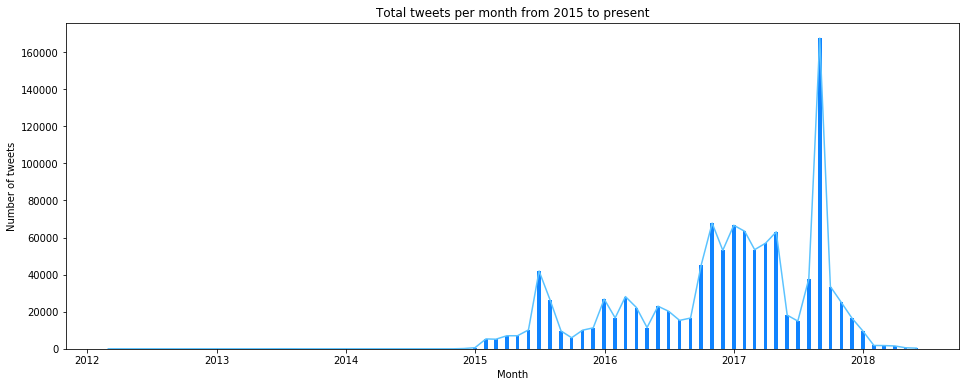

In [19]:
tweet_times = get_tweet_count(df)
monthly = tweet_times.resample('M').sum()
fig2, ax2 = plt.subplots(1,1, figsize=(16,6))
ax2.bar(monthly.index.values, monthly["tweet_count"].values, width=10, color="#0f83ff")
ax2.plot(monthly["tweet_count"], color="#5bc3ff")
ax2.set_title("Total tweets per month from 2015 to present")
ax2.set_xlabel("Month")
ax2.set_ylabel("Number of tweets")
plt.show()

We recognize some peaks in the plot above. Let's see which months correspond to a high tweet activity.

In [20]:
monthly.replace(np.nan,0).sort_values('tweet_count',ascending= False).head(10)

,tweet_count
publish_date,
2017-08-31,167539
2016-10-31,67779
2016-12-31,66625
2017-01-31,63367
2017-04-30,63080
2017-03-31,56979
2017-02-28,53465
2016-11-30,53096
2016-09-30,45161


We can see that the tweets count increases in specific months. This may be due to an elaborate focus on events happening in those time slots. The aim now is to try to understand what caused the peak activity.
To do so, we have to dive in into more narrow time periods. We therefore aggregate the count of tweets per day.

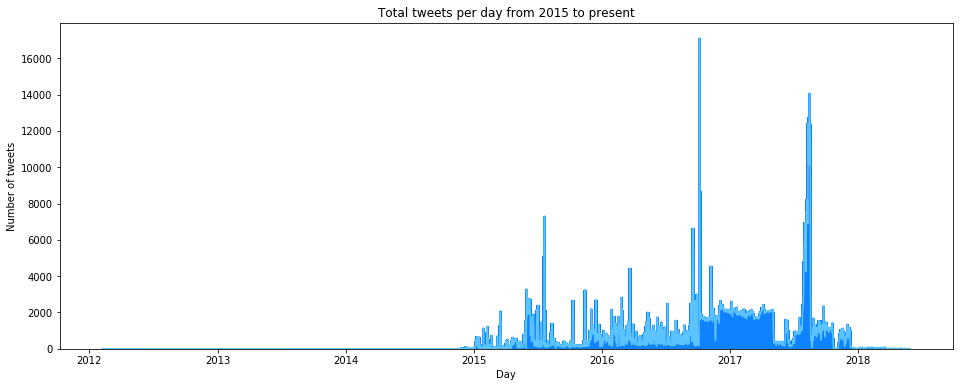

In [21]:
daily = tweet_times.resample('D').sum()
fig2, ax2 = plt.subplots(1,1, figsize=(16,6))
ax2.bar(daily.index.values, daily["tweet_count"].values, width=10, color="#0f83ff")
ax2.plot(daily["tweet_count"], color="#5bc3ff")
ax2.set_title("Total tweets per day from 2015 to present")
ax2.set_xlabel("Day")
ax2.set_ylabel("Number of tweets")
plt.show()

In [22]:
daily.sort_values('tweet_count',ascending= False).head(10)

,tweet_count
publish_date,
2016-10-06,17107
2017-08-16,14079
2017-08-15,12766
2017-08-12,12409
2017-08-17,12367
2017-08-18,11933
2017-08-13,10369
2017-08-14,10145
2016-10-07,8715


In [23]:
daily.describe()

,tweet_count
count,2306.000000
mean,485.616219
std,1132.453232
min,0.000000
25%,0.000000
50%,22.000000
75%,468.750000
max,17107.000000


We can see that the standard deviation of the daily tweet count is more than double the mean. This puts an emphasis over the idea that the IRA strategy deliberately focuses on specific days. It's hard to manually match each daily activity with the corresponding event but we can approximate them by taking different meaningful time periods and also investigating largely mediatized events. We proceed by dividing the timeline into 3 periods: before the compaign, during the compaign and after the compaign. 

In [24]:
times_before = tweet_times.loc[(tweet_times.index < "2015-06-16 00:00:01")]
times_compaign = tweet_times.loc[(tweet_times.index >= "2015-06-16 00:00:01") 
                                 & (tweet_times.index < "2016-11-09 23:59:59")]
times_pres = tweet_times.loc[(tweet_times.index >= "2016-11-09 00:00:01")]

# Display the months with the largest tweet counts before the compaign
monthly_before = times_before.resample('M').sum().replace(np.nan,0).sort_values('tweet_count',ascending= False)
monthly_before.head(10)

,tweet_count
publish_date,
2015-06-30,32045
2015-05-31,10164
2015-03-31,7041
2015-04-30,7040
2015-01-31,5330
2015-02-28,5165
2014-12-31,606
2014-11-30,143
2013-06-30,32


In [25]:
# Display the months with the largest tweet counts during the compaign
monthly_compaign = times_compaign.resample('M').sum().replace(np.nan,0).sort_values('tweet_count',ascending= False)
monthly_compaign.head(10)

,tweet_count
publish_date,
2016-10-31,67779
2016-09-30,45161
2016-02-29,28161
2015-12-31,26792
2015-07-31,26402
2016-05-31,22971
2016-03-31,22267
2016-06-30,20236
2016-11-30,19281


During the compaign, the month with the greatest tweet activity is October 2016 which is the month before the 2016 presidential elections. Obviously, the IRA will scramble all its assets just before the voting day.

In [26]:
# Display the months with the largest tweet counts after the compaign
monthly_after = times_pres.resample('M').sum().replace(np.nan,0).sort_values('tweet_count',ascending= False)
monthly_after.head(10)

,tweet_count
publish_date,
2017-08-31,167539
2016-12-31,66625
2017-01-31,63367
2017-04-30,63080
2017-03-31,56979
2017-02-28,53465
2017-07-31,37666
2016-11-30,36968
2017-09-30,33569


Let's look at some events and try to see the corresponding monthly and daily tweet counts 

### Octobre 2016
We can see a surge in the tweets on October 6th and 7th. This can be probably explained by the second presdidential debate on the 9th. In the same sense, there is an increase (although less important) on October 19th for the 3rd presidential debate.

### August 2017
We can see that the spike in tweets from August 12 to August 18 2016. This can be explained by the fact that at the 12th a white supremacist rally occured and was followed by a peacefull protests in CharlottesVille Viriginia. A car crashed into the protestors killing one and injuring 28. This incident was intensely covered by the US media and stayed in the spotlight for a while especially after the  famous comment tweeted by Trump: “You had some very bad people in that group. But you also had people that were very fine people, on both sides.”
https://en.wikipedia.org/wiki/Charlottesville_car_attack


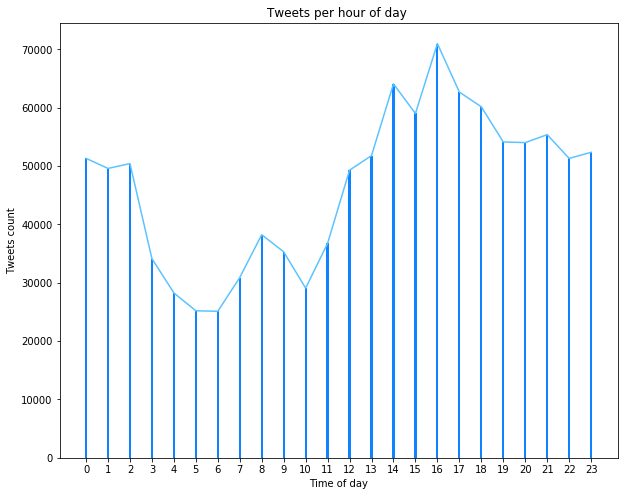

In [27]:
times = tweet_times
df1 = times.pivot_table(index=times.index.hour,
                        values='tweet_count', 
                        aggfunc='sum')

fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.bar(df1.index.values, df1["tweet_count"], width=0.1, color="#0f83ff")
ax3.plot(df1["tweet_count"], color="#5bc3ff")
ax3.set_title("Tweets per hour of day ")
ax3.set_xlabel("Time of day")
ax3.set_ylabel("Tweets count")
plt.xticks(np.arange(24))
plt.show()

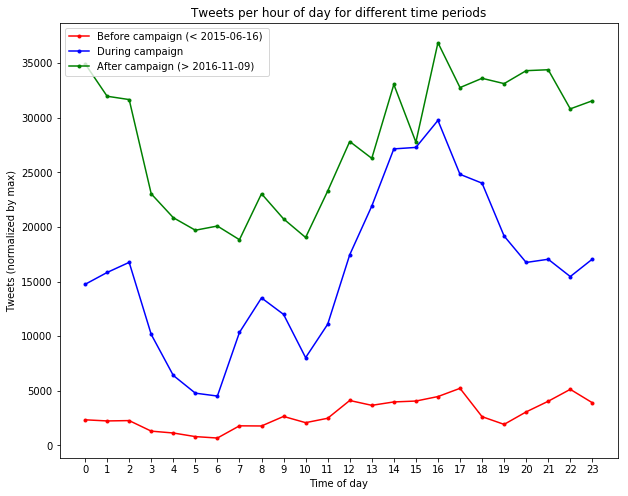

In [28]:
def times_to_hour(tweet_times_series):
    df_temp = tweet_times_series.pivot_table(
                    index=tweet_times_series.index.hour,
                    values='tweet_count', 
                    aggfunc='sum')
    return df_temp

df_b = times_to_hour(times_before)
df_c = times_to_hour(times_compaign)
df_p = times_to_hour(times_pres)

fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.plot(df_b["tweet_count"], 'r.-')
ax3.plot(df_c["tweet_count"], 'b.-')
ax3.plot(df_p["tweet_count"], 'g.-')
plt.legend(["Before campaign (< 2015-06-16) ", "During campaign", "After campaign (> 2016-11-09)"])
ax3.set_title("Tweets per hour of day for different time periods")
ax3.set_xlabel("Time of day")
ax3.set_ylabel("Tweets (normalized by max)")
plt.xticks(np.arange(24))
plt.show()

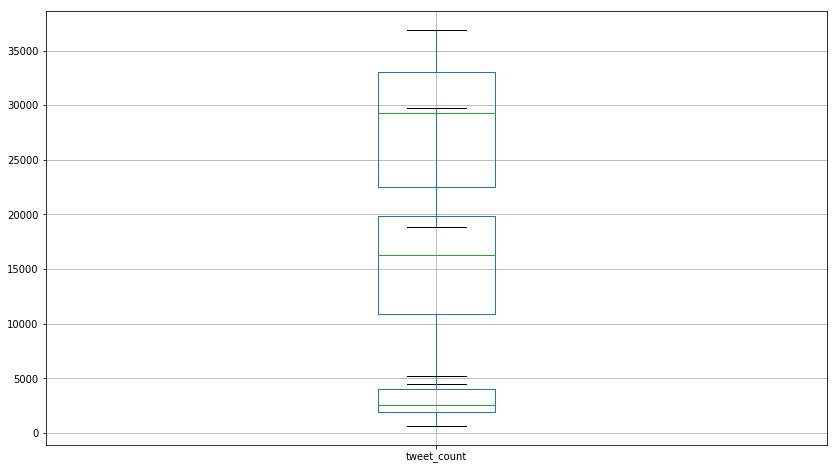

In [29]:
# TODO adjust boxplots 
df_c.boxplot('tweet_count',grid=True,figsize=(14,8))
df_b.boxplot('tweet_count')
df_p.boxplot('tweet_count')

The upper boxplot: after the elections
The boxplot in the middle: during the compaign
The lower boxplot: before the compaign

After the compaign at any hour of the day the number of tweets is higher than the maximum hourly number of tweets during the compaign. The same applies to during the compaign and before it.
This is actually very insightfull. It means the IRA was much less interested in interfering with the political process before Donald Trump announced his candidacy. Then when he did, they strongly increased the tweeting frequency until he won. After the elections, the IRA was even more interested in compromising the public opinion. Of course, this is only an approximation since we don't have the logs of all the IRA's activity but this is a good indicator that they beef up their effort everytime they achieve something (assuming that they backed Donald Trump).

In [30]:
# Let's get the aggregate number of tweets for the 3 time periods for the right trolls and left trolls
df_right = df[(df.account_category=='RightTroll')]
df_left = df[(df.account_category=='LeftTroll')]
tweet_times_right = get_tweet_count(df_right)
tweet_times_left = get_tweet_count(df_left)

times_before_left = tweet_times_left.loc[(tweet_times_left.index < "2015-06-16 00:00:01")]
times_compaign_left = tweet_times_left.loc[(tweet_times_left.index > "2015-06-16 00:00:01") 
                                 & (tweet_times_left.index < "2016-11-09 23:59:59")]
times_pres_left = tweet_times_left.loc[(tweet_times_left.index > "2016-11-09 00:00:01")]

times_before_right = tweet_times_right.loc[(tweet_times_right.index < "2015-06-16 00:00:01")]
times_compaign_right = tweet_times_right.loc[(tweet_times_right.index > "2015-06-16 00:00:01") 
                                 & (tweet_times_right.index < "2016-11-09 23:59:59")]
times_pres_right = tweet_times_right.loc[(tweet_times_right.index > "2016-11-09 00:00:01")]


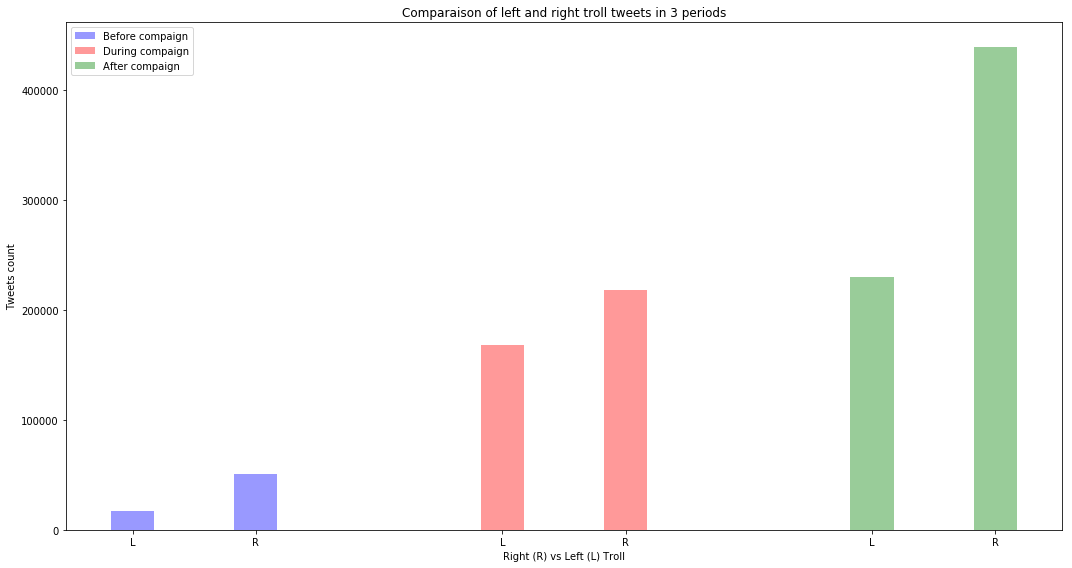

In [31]:
bar_width = 0.35
before_compaign = [len(times_before_left),len(times_before_right)]
during_compaign = [len(times_compaign_left),len(times_compaign_right)]
after_compaign = [len(times_pres_left),len(times_pres_right)]

f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
opacity = 0.4
error_config = {'ecolor': '0.3'}
index_1 = [0,1]
index_2 = [3,4]
index_3 = [6,7]
index = index_1+index_2+index_3

ax.bar(index_1, before_compaign, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Before compaign')
ax.bar(index_2, during_compaign, bar_width,
                 alpha=opacity,
                 color='r',
                 label='During compaign')

ax.bar(index_3, after_compaign, bar_width,
                 alpha=opacity,
                 color='g',
                 label='After compaign')



plt.xlabel('Right (R) vs Left (L) Troll')
plt.ylabel('Tweets count')
plt.title('Comparaison of left and right troll tweets in 3 periods')
plt.xticks(index, ('L','R','L','R','L','R'))
plt.legend()

plt.tight_layout()
plt.show()

Overall, the number of tweets by right trolls is larger than the left trolls. The difference grows to almost the double after the elections. The idea here is that left trolls will divide the left and liberal agenda and to some extent give ways for the conservative and right agenda to prevail. After the compaign, this is not anymore the objective. the goal becomes how to better defend the president-elect and discredit his critics.

## Sentiment Analysis

In [32]:
# Let's first tokenize the tweets
tokenized_tweet = df['content'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [have, sitting, Democrat, Senator, trial, corruption, barely, heard, peep, from, mainstream, media]                
1    [Marshawn, Lynch, arrives, game, anti, Trump, shirt, Judging, sagging, pants, shirt, should, Lynch, belt]          
2    [Daughter, fallen, Navy, Sailor, delivers, powerful, monologue, anthem, protests, burns, packers, gear, BoycottNFL]
3    [JUST, President, Trump, dedicates, Presidents, golf, tournament, trophy, people, Florida, Texas, Puerto, Rico]    
4    [RESPECTING, National, Anthem, StandForOurAnthemðŸ]                                                                
Name: content, dtype: object

In [33]:
# Now, we stemm the tokens to their roots
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [have, sit, democrat, senat, trial, corrupt, bare, heard, peep, from, mainstream, media]                 
1    [marshawn, lynch, arriv, game, anti, trump, shirt, judg, sag, pant, shirt, should, lynch, belt]          
2    [daughter, fallen, navi, sailor, deliv, power, monologu, anthem, protest, burn, packer, gear, boycottnfl]
3    [just, presid, trump, dedic, presid, golf, tournament, trophi, peopl, florida, texa, puerto, rico]       
4    [respect, nation, anthem, standforouranthemðÿ]                                                           
Name: content, dtype: object

In [34]:
# Let's join the stemmed words and put them in the dataframe
df['tidy_content'] = tokenized_tweet.apply(' '.join)

In [35]:
df['tidy_content'].head()

0    have sit democrat senat trial corrupt bare heard peep from mainstream media                
1    marshawn lynch arriv game anti trump shirt judg sag pant shirt should lynch belt           
2    daughter fallen navi sailor deliv power monologu anthem protest burn packer gear boycottnfl
3    just presid trump dedic presid golf tournament trophi peopl florida texa puerto rico       
4    respect nation anthem standforouranthemðÿ                                                  
Name: tidy_content, dtype: object

In [36]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


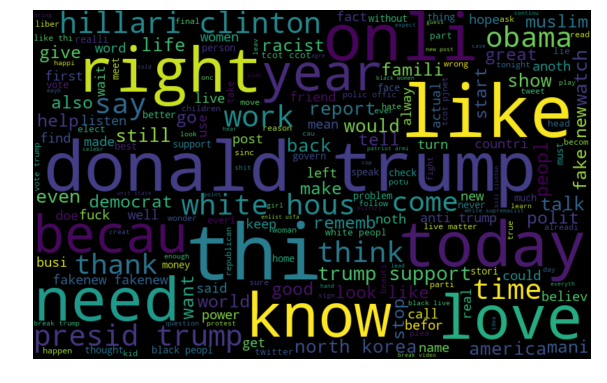

In [37]:
#Let's look at some frequent words
all_words = ' '.join([text for text in df['tidy_content']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords=stopwords).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Topic detection

In [ ]:
'''


Given the IRA tweets we would like to extract, for each tweet, hidden topics. More so our idea would be to associate such topics to specific windows of time and events which happened on that period.

In order to do so we decided to use Latent Dirichlet Allocation (LDA) that is a popular algorithm for topic modeling. The main challenge is how to extract good quality of topics that are clear and meaningful. 
This point is mainly related to:
1. quality of text processing
2. strategy of finding an optimal amount of topics.

We first start by the text processing. 
Five main steps have been performed:  
1. Tokenization  
2. Filtering tokens 
3. Removing all the stopwords
4. Lemmatization 
5. Stemming 
In the first place we needed to split the text of each tweet into sentences and the sentences into words (Tokenization). Lowercase the words and remove punctuation.
After that we filter tokens that appear in less than 15 documnets or more than 0.5 documents. More so we decided to keep only the first 100000 most frequent tokens. 
For each document we create a dictionary reporting how man words and how many times those words appear (Bag of Words). We also decided to create a tf-idf model object in order to have two possible models to be used in the LDA process. Such a choice is mainly due to the possibility that one model can perform better than another.
Once the so called "Bag of Words" and the "TF-IDF" models have been created, we could train our LDA model. In this way for each topic, we will explore the words occuring in that topic and its relative weight. The same procedure can be applied for the "TF-IDF" model.

The most tricky part, according to us, is the definition of the number of the topic to be used in the LDA training. In order to do this two main approaches will be used:
1. Checking a specfic number of topics that we think we should find in our dataset, training the LDA and subjectively inspecting the validity of the final groups (e.g. topics), possibly iterating the process with another amount of topics.
2. Definig scores that can help us in automatically identify the correct number of topics, inspecting the final result to check whether it makes sense.

Right now we tested the second strategy and in particular we used model perplexity and topic coherence (https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. However, also in this case, the human expert will be afterwards in charge of evaluating the final result.

We are currently evaluating the obtained results and we will switch to the first approach (see above) only in case we will not find a significant topic identification.

To make the process cleaner, the initial dataset has been extended of two columns, one indicating the year and the other the month, such that we can slice the dataset according to the year/month pair we are interest in. This will allow us to select a group of topics related to a specific windows of time. This is really important afterwards when we would like to associate the most popular topics with a specific event that happened on that period of time.ß

'''

In [38]:
stemmer = PorterStemmer()

In [39]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [40]:
def create_dictionary(document):
    """
    "doc" is a dataframe with the column of tweets we want to analyze. E.g. doc = df[['content']]
    Usage : dictionary = create_dictionary(df[['content']])
    """

    # We add an index column
    data_text= document
    data_text['index'] = document.index
    documents = data_text
    # Process the doc text, saving the result as "processed_docs" 
    processed_docs = documents[documents.columns.values[0]].iloc[0:20000].map(preprocess)
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    return processed_docs, dictionary, bow_corpus

In [41]:
def extract_topic(processed_docs, dictionary, bow_corpus, topic_num, method, compute_scores):
    """
    This function is created to find "topic_num" topics 
    from a specific "method", e.g. Bag-of-Words or TF-IDF, respectively 0 and 1, to represent text 
     stored in the "dictionary", which is a Gensim dictionary
     Finally compute_score is a boolean value: true or 1 if the scores should be computed
    
    Outputs: lda_model, bow_corpus, perpl, coherence_lda, processed_docs
    Example of Usage: 
    processed_docs, dictionary, bow_corpus = create_dictionary(df[['content']])
    lda_model, bow_corpus, score1, score2, proces_docs = extract_topic(processed_docs, dictionary, bow_corpus, num_topics, 0, 1)
    """
    
    
    # Filter out tokens that appear in less than 15 documents (absolute number) 
    #or more than 0.5 documents (fraction of total corpus size, not absolute number).
    #after the above two steps, keep only the first 100000 most frequent tokens

    # Gensim doc2bow For each document we create a dictionary reporting how many words and how many times those words appear.
    # Save this to ‘bow_corpus’, then check our selected document earlier.
    #TF-IDF Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation 
    #to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document
    if (method == 1):
        tfidf = models.TfidfModel(bow_corpus)
        corpus_tfidf = tfidf[bow_corpus]
        # Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
        lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topic_num, id2word=dictionary, passes=2, workers=4)
    else:
        # Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=topic_num, id2word=dictionary, passes=2, workers=2)
    if (compute_scores):
        perpl = lda_model.log_perplexity(bow_corpus)  # a measure of how good the model is. lower the better.
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
    else:
        perpl=0
        coherence_lda=0
    return lda_model, bow_corpus, perpl, coherence_lda, processed_docs

In [42]:
def compute_coherence_values(processed_docs, dictionary, bow_corpus , limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    processed_docs
    dictionary
    bow_corpus
    doc : Gensim dictionary
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    
    Usage:
    --------
    model_list, coherence_values = compute_coherence_values(processed_docs, dictionary, bow_corpus, 3, start=2, step=1)
    """
    coherence_values_list = []
    model_list = []
    proces_docs = []
    for num_topics in range(start, limit, step):
        lda_model, bow_corpus, score1, score2, proces_docs = extract_topic(processed_docs, dictionary, bow_corpus, num_topics, 0, 1)
        model_list.append(lda_model)
        coherence_values_list.append(score2)

    return model_list, coherence_values_list

In [43]:
def show_models(model_list, coherence_values,  limit, start, step):
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [44]:
df_rightTroll = df[df['account_category'] == 'RightTroll']
df_english = df_rightTroll[df_rightTroll['language']=='English']
data_text = df_english[['content']]
processed_docs, dictionary, bow_corpus = create_dictionary(data_text)

C:\Users\Ahmed\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [45]:
model_list, coherence_values = compute_coherence_values(processed_docs, dictionary, bow_corpus, 5, 2, 1)

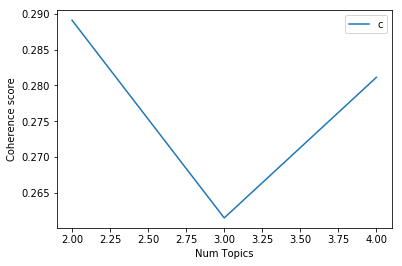

In [46]:
show_models(model_list, coherence_values,5, 2, 1 )

In [47]:
# Show topic
# Select one model from the model list
lda_model = model_list[0]
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.038*"trump" + 0.016*"enlist" + 0.011*"ade" + 0.010*"obama" + 0.010*"break" + 0.009*"presid" + 0.007*"news" + 0.007*"usfa" + 0.007*"media" + 0.007*"patriot"
Topic: 1 
Words: 0.045*"enlist" + 0.026*"patriot" + 0.019*"armi" + 0.015*"america" + 0.013*"usfa" + 0.011*"ade" + 0.011*"peopl" + 0.010*"need" + 0.009*"want" + 0.008*"stand"


In [48]:
#test with only one model

#df_rightTroll = df[df['account_category'] == 'RightTroll']
#df_english = df_rightTroll[df_rightTroll['language']=='English']
#data_text = df_english[['content']]

In [49]:
#processed_docs, dictionary, bow_corpus = create_dictionary(data_text)
#lda_model, bow_corpus, score1, score2, proces_docs = extract_topic(processed_docs, dictionary, bow_corpus, 2, 0, 1)

In [50]:
# Let's add two new columns containing the years and the months of the publish date
df['year'] = pd.DatetimeIndex(df['publish_date']).year
df['month'] = pd.DatetimeIndex(df['publish_date']).month
#df.to_csv('df_extended.csv')

In [51]:
# Filter data with respect to English language
df_reduced = df[df['account_category'] == 'RightTroll']
df_reduced = df_reduced[df_rightTroll['language']=='English']

# Filter data with respect to the month and year
# I create as many dictonary as the number of years 
year_2017 = {}
year_2016 = {}
year_2015 = {}

months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [52]:
# Each dictonary contains for each month a dataset filtered from df with respect to the month and the year
for month in months:
    year_2017[month] = df_reduced[df_reduced['month']==int(month) & (df_reduced['year']==2017)]
    year_2016[month] = df_reduced[(df_reduced['month']==int(month)) & (df_reduced['year']==2016)]
    year_2015[month] = df_reduced[(df_reduced['month']==int(month)) & (df_reduced['year']==2015)]

In [53]:
# Test one dataset inside the dictionary "year_2017" related to month = January 
data_text = year_2017['1'][['content']]
processed_docs, dictionary, bow_corpus = create_dictionary(data_text)
model_list, coherence_values = compute_coherence_values(processed_docs, dictionary, bow_corpus, 5, 2, 1)

C:\Users\Ahmed\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


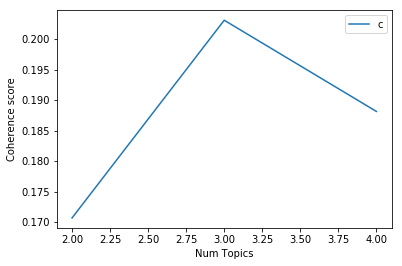

In [54]:
show_models(model_list, coherence_values,5, 2, 1 )

In [55]:
lda_model = model_list[0]
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.046*"trump" + 0.015*"obama" + 0.013*"presid" + 0.008*"inaugur" + 0.008*"year" + 0.008*"maga" + 0.007*"peopl" + 0.007*"america" + 0.007*"say" + 0.006*"american"
Topic: 1 
Words: 0.012*"news" + 0.010*"trump" + 0.009*"like" + 0.009*"obama" + 0.006*"know" + 0.006*"leav" + 0.006*"peopl" + 0.006*"think" + 0.005*"want" + 0.005*"isi"


# Sentiment classifier

In [56]:
def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob((tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [57]:
# Let's calculate the polarity of each tweet
df['polarity'] = df.tidy_content.apply(analyze_sentiment) 

In [58]:
df.groupby(['polarity']).size()

polarity
-1    182277
 0    657726
 1    279828
dtype: int64

Most of the tweets come out as neutral in terms of polarity. The count for the positive tweets if greater than the negative ones.

Using the polarity alone, it's hard to say whether the labels we get are correct or not. We can't benchmark unless we label the data ourselves which is cumbersome and takes a long time. Instead, we will use another twitter dataset that was labeled to positive and negatives sentiments. The dataset has 1.600000 datapoints and was labeled using the emojis in them. For example a :) corresponds to a positive tweet and a :( corresponds to a negative tweet.
You can find the dataset here https://www.kaggle.com/kazanova/sentiment140 and the corresponding paper https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

The idea is to train and test a classfier using this dataset and then apply it on our IRA data.

In [59]:
df_labeled = pd.read_csv('distant_labeled_data.csv',encoding = "ISO-8859-1", header=None).iloc[:, [0, 4, 5]]
df_labeled.columns = ['sentiment','user','content']
df_labeled.head()

,sentiment,user,content
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [60]:
# 0 corresponds to negative sentiment and 4 to positive sentiment
np.unique(df_labeled.sentiment) 

array([0, 4], dtype=int64)

In [61]:
# clean tweets using the function defined before
users = np.array(df_labeled.iloc[:, 1].values)
tweets = np.array(df_labeled.iloc[:, 2].apply(preprocess_tweet).values)
sentiment = np.array(df_labeled.iloc[:, 0].values)
print(tweets)

['   Awww  that bummer shoulda David Carr Third'
 ' upset that update Facebook texting might result School today also  Blah '
 ' dived many times ball  Managed save rest bounds' ...
 ' ready your MoJo Makeover details '
 'Happy Birthday alll time    Tupac Amaru Shakur ' 'happy charitytuesday ']


In [62]:
vocab_size = 4000
# tokenizing tweets and arranging them into sequences to feed the model
tk = Tokenizer(num_words=vocab_size)
#tw = tweets
tk.fit_on_texts(tweets)
t = tk.texts_to_sequences(tweets)
X = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))
y = sentiment

print(X.shape, y.shape)

(1600000, 20) (1600000,)


In [63]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.models import load_model
y[y == 4] = 1 # changing the positive label to 1 instead of 4

# building a model

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=20))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            128000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            24640     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 64)             0         
__________

In [64]:
'''
history = model.fit(X, y, batch_size=128, verbose=1, validation_split=0.2, epochs=10)
model.save('model.h5')
model = load_model('model.h5')
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.savefig('Figure 1')

plt.plot(history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('Figure 1')
'''

"\nhistory = model.fit(X, y, batch_size=128, verbose=1, validation_split=0.2, epochs=10)\nmodel.save('model.h5')\nmodel = load_model('model.h5')\nplt.plot(history.history['loss'])\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.show()\nplt.savefig('Figure 1')\n\nplt.plot(history.history['acc'])\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.show()\nplt.savefig('Figure 1')\n"

In [65]:
# load the model
model = load_model('model.h5')

Now, let's arrange our dataset to test the model

In [66]:
df.tidy_content = df.tidy_content.astype(str)
df = df.iloc[:100,:]
users = np.array(df.author.values)
tweets = np.array(df.content.values)
print(tweets[:10])
vocab_size = 4000
tk = Tokenizer(num_words=vocab_size)
#tw = tweets
tk.fit_on_texts(tweets)
t = tk.texts_to_sequences(tweets)
X = np.array(sequence.pad_sequences(t, maxlen=20, padding='post'))

[' have sitting Democrat Senator trial corruption barely heard peep from mainstream media     '
 'Marshawn Lynch arrives game anti Trump shirt  Judging sagging pants shirt should Lynch  belt '
 'Daughter fallen Navy Sailor delivers powerful monologue anthem protests  burns packers gear  BoycottNFL '
 'JUST  President Trump dedicates Presidents golf tournament trophy people Florida  Texas Puerto Rico  '
 '  RESPECTING National Anthem  StandForOurAnthemðŸ   '
 ' Bongino   Nobody trolls liberals better than Donald Trump   Exactly  '
 '   '
 '  Doesn matter that doesn report your crimes  This change fact that going down  '
 ' much hate promoting article  here they admitting EVERYTHING Trump said about relief days  '
 'After  genocide  remark from Juan Mayor narrative changed though  fixes reporting constantly ']


In [67]:
y_pred = model.predict_classes(X)

In [68]:
df['sentiment']= y_pred

In [69]:
pd.set_option('display.max_colwidth', -1)
df.iloc[:20]

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,tidy_content,year,month,polarity,sentiment
0,9.060000e+17,10_GOP,have sitting Democrat Senator trial corruption barely heard peep from mainstream media,Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll,have sit democrat senat trial corrupt bare heard peep from mainstream media,2017,10,-1,0
1,9.060000e+17,10_GOP,Marshawn Lynch arrives game anti Trump shirt Judging sagging pants shirt should Lynch belt,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll,marshawn lynch arriv game anti trump shirt judg sag pant shirt should lynch belt,2017,10,-1,0
2,9.060000e+17,10_GOP,Daughter fallen Navy Sailor delivers powerful monologue anthem protests burns packers gear BoycottNFL,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll,daughter fallen navi sailor deliv power monologu anthem protest burn packer gear boycottnfl,2017,10,0,0
3,9.060000e+17,10_GOP,JUST President Trump dedicates Presidents golf tournament trophy people Florida Texas Puerto Rico,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll,just presid trump dedic presid golf tournament trophi peopl florida texa puerto rico,2017,10,0,0
4,9.060000e+17,10_GOP,RESPECTING National Anthem StandForOurAnthemðŸ,Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll,respect nation anthem standforouranthemðÿ,2017,10,0,0
5,9.060000e+17,10_GOP,Bongino Nobody trolls liberals better than Donald Trump Exactly,Unknown,English,10/1/2017 2:47,10/1/2017 2:47,1050,9644,247,NaN,Right,0,0,RightTroll,bongino nobodi troll liber better than donald trump exactli,2017,10,1,0
6,9.060000e+17,10_GOP,,Unknown,English,10/1/2017 2:48,10/1/2017 2:48,1050,9644,248,RETWEET,Right,0,1,RightTroll,,2017,10,0,0
7,9.060000e+17,10_GOP,Doesn matter that doesn report your crimes This change fact that going down,Unknown,English,10/1/2017 2:52,10/1/2017 2:53,1050,9644,249,NaN,Right,0,0,RightTroll,doesn matter that doesn report your crime thi chang fact that go down,2017,10,-1,1
8,9.060000e+17,10_GOP,much hate promoting article here they admitting EVERYTHING Trump said about relief days,Unknown,English,10/1/2017 3:47,10/1/2017 3:47,1050,9646,250,NaN,Right,0,0,RightTroll,much hate promot articl here they admit everyth trump said about relief day,2017,10,-1,0
9,9.060000e+17,10_GOP,After genocide remark from Juan Mayor narrative changed though fixes reporting constantly,Unknown,English,10/1/2017 3:51,10/1/2017 3:51,1050,9646,251,NaN,Right,0,0,RightTroll,after genocid remark from juan mayor narr chang though fix report constantli,2017,10,0,0


# IRA tweet classifier